<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Flooded area segmentation using attention unet

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Imports and dataset**

In [82]:
!pip install keras-tuner -q

In [83]:
!pip install focal_loss -q

In [84]:
!pip install tensorflow --upgrade

In [85]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import glob

In [86]:
images = sorted(glob.glob('/content/drive/MyDrive/archive/Image/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/archive/Mask/*.png'))
len(images), len(masks)

(290, 290)

**Custom data generator**

In [87]:
import numpy as np
import cv2
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, img_size=(512, 512), shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.images = images #os.listdir(image_folder)
        self.masks = masks #os.listdir(mask_folder)

        # on each epoch end, shuffle the dataset
        self.on_epoch_end()

        # datagen function to augment the input image and mask pair
        self.datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'constant',
            cval=0.0,
        )

    # randomly crop the images to 512x512 size
    def random_crop(self, image, mask, crop_size=512):

        # image width and height calculation
        img_height, img_width = image.shape[0], image.shape[1]
        mask_height, mask_width = mask.shape[0], mask.shape[1]

        # random x and y coordinate for cropping the image
        x = np.random.randint(0, img_width - crop_size)
        y = np.random.randint(0, img_height - crop_size)

        # random crop
        image_crop = image[y:y + crop_size, x:x + crop_size, :]
        mask_crop = mask[y:y + crop_size, x:x + crop_size]

        return image_crop, mask_crop

    # data augmentation using keras ImageDataGenerator function
    def data_augmentation(self, image, mask):
        trans_param = self.datagen.get_random_transform(image.shape)
        image = self.datagen.apply_transform(image, trans_param)
        mask = self.datagen.apply_transform(mask, trans_param)
        return image, mask

    # length of the processing batch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    # data normalization
    def data_normalization(self, image, mask):

        # reshape mask from 512x512 to 512x512x1
        mask = mask.reshape((*self.img_size, 1))

        # Binary mask
        mask = np.where(mask<127, 0, 1)

        # data normalization (If you want to normalize another way, change the below line)
        image = image / 255.0

        # return image and mask
        return image, mask

    # data preprocessing, resize, crop image etc
    def data_preprocessing(self, image, mask):
        image, mask = cv2.resize(image, (576, 576)), cv2.resize(mask, (576, 576))
        image, mask = self.random_crop(image, mask)
        return image, mask

    # on each epoch, shuffle the dataset (image and mask index)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # get item is the core function
    # this function will run in each batch/epoch to load the dataset into RAM and pass to DL model
    def __getitem__(self, index):

        # start and end index
        # the last index can be shorter than the number of batches
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        indexes = self.indexes[start_idx:end_idx]

        # initialize the images and mask batches
        batch_images = []
        batch_masks = []

        # iterate over each indexes in batch
        for i in indexes:
            img_path = self.images[i]
            mask_path = self.masks[i]

            # read image using open cv
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Skip if image or mask is not loaded properly
            if img is None or mask is None:
                continue

            # image preprocessing; resize, random crop
            img, mask = self.data_preprocessing(img, mask)

            # data normalization
            img, mask = self.data_normalization(img, mask)

            # data augmentation
            img, mask = self.data_augmentation(img, mask)

            # to fix the issue during training process
            mask = mask.astype(np.float32)

            # append each image, mask pair to the batches
            batch_images.append(img)
            batch_masks.append(mask)

        # return batch image and batch mamks as a numpy array (n, tile_x, tile_y, channels)
        return np.array(batch_images), np.array(batch_masks)

**Train and test dataset split**

In [88]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=42)

In [89]:
len(train_img), len(test_img)

(232, 58)

In [90]:
# Initialize the generators
train_dataset = CustomDataGenerator(train_img, train_mask)
test_dataset = CustomDataGenerator(test_img, test_mask)

In [91]:
len(train_dataset), len(test_dataset)

(29, 8)

**Custom metrics**

1.   Precision
2.   Recall
3.   F1-Score
4.   Dice loss



**Custom loss function**

In [92]:
import tensorflow as tf
from tensorflow.keras import backend as K

# precision
def precision_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# recall
def recall_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

**Testing and visualization of image/mask pair**

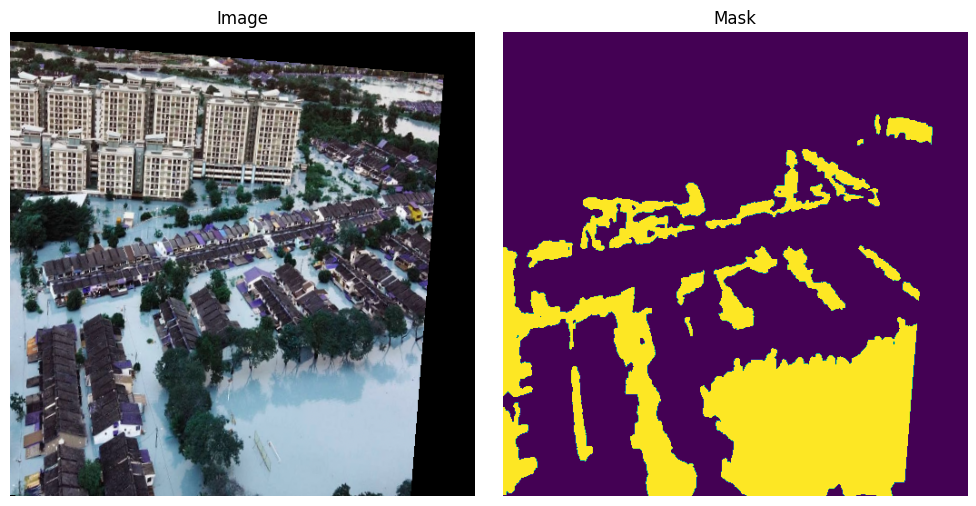

In [93]:
import matplotlib.pyplot as plt

data = CustomDataGenerator(images, masks)
batch_images, batch_masks = data.__getitem__(0)

img = np.random.randint(0,8)
# Visualize the first image and its mask from the batch
image = batch_images[img]
mask = batch_masks[img]

# Plotting the image and its mask
plt.figure(figsize=(10, 5))

# Display Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

# Display Mask
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

**Attention UNET**

In [94]:
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
from tensorflow.keras.layers import UpSampling2D, multiply

# 注意力門控區塊（Attention Gating Block）:
# x：來自編碼路徑的特徵圖，通常具有較大的空間解析度。
# g：來自解碼路徑的特徵圖，通常具有較小的空間解析度。
# inter_shape：中間層的通道數，用於縮減特徵圖的通道數以減少計算量。
# activation：激活函數的類型，通常為 relu。
# name：層的名稱前綴，用於命名每個操作，以便在模型中區分不同的層。
def AttnGatingBlock(x, g, inter_shape, activation, name):
    ''' take g which is the spatially smaller signal, do a conv to get the same
    number of feature channels as x (bigger spatially)
    do a conv on x to also get same geature channels (theta_x)
    then, upsample g to be same size as x
    add x and g (concat_xg)
    relu, 1x1 conv, then sigmoid then upsample the final - this gives us attn coefficients'''

    shape_x = x.shape  # 32
    shape_g = g.shape  # 16


    # theta_x：對 x 進行卷積操作，將空間解析度縮小一半，並將通道數減少到 inter_shape。
    # phi_g：對 g 進行1x1卷積，將其通道數減少到 inter_shape，這樣 g 和 x 的通道數相同。
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x)  # 16
    shape_theta_x = theta_x.shape

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    # upsample_g：對 g 進行轉置卷積，將其空間解析度擴大到與 theta_x 一致。這一步是為了讓 g 和 x 在空間解析度上相匹配。
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)  # 16

    # concat_xg：將上採樣後的 g 和 theta_x 相加。
    # act_xg：對相加結果應用激活函數，通常是 relu。
    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation(activation)(concat_xg)
    # psi：對激活後的特徵圖進行 1x1 卷積，將其通道數縮減為 1。
    # sigmoid_xg：對 psi 的輸出進行 sigmoid 激活，生成一個權重圖（注意力係數），每個值都在 0 到 1 之間。
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = sigmoid_xg.shape

    # upsample_psi：將注意力係數圖 sigmoid_xg 上採樣到與 x 的空間解析度相同。
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    # Expand upsample_psi to match the number of channels in shape_x[3]/expend_as：將 upsample_psi 擴展到與 x 相同的通道數。
    # upsample_psi = expend_as(upsample_psi, shape_x[3], name)

    # Multiply with x/ y：將注意力權重圖 upsample_psi 與原始特徵圖 x 逐元素相乘，這一步突出重要的區域。
    y = multiply([upsample_psi, x], name='q_attn' + name)
    # result：通過 1x1 卷積將通道數恢復到與 x 相同。
    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    # result_bn：對結果進行批量正規化，以穩定訓練過程。
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    return result_bn

# UnetConv2D：實現 U-Net 中的基本卷積塊，通過兩層 3x3 卷積、選擇性批量正規化和激活，提取圖像特徵。
def UnetConv2D(input, outdim, is_batchnorm, activation, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)

	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x



In [95]:
# UnetGatingSignal：生成門控信號，通過 1x1 卷積來壓縮特徵圖的維度，用於注意力機制中。

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation

def UnetGatingSignal(input, is_batchnorm, name):
    ''' this is simply 1x1 convolution, bn, activation '''
    shape = input.shape
    x = Conv2D(shape[3] * 1, (1, 1), strides=(1, 1), padding="same",  kernel_initializer=kinit, name=name + '_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name + '_bn')(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

K.set_image_data_format('channels_last')  # TF dimension ordering in this code  # 設置 TensorFlow 的維度順序
kinit = 'glorot_normal' # # 權重初始化方法

def attn_unet(lr, loss_func=None, pretrained_weights=None,input_size = (512,512,3)):
    inputs = Input(shape=input_size)

    conv1 = UnetConv2D(inputs, 64, is_batchnorm=True, activation='relu', name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = UnetConv2D(pool1, 64, is_batchnorm=True, activation='relu', name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = UnetConv2D(pool2, 128, is_batchnorm=True, activation='relu', name='conv3')
    conv3 = Dropout(0.1,name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = UnetConv2D(pool3, 128, is_batchnorm=True, activation='relu', name='conv4')
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = UnetConv2D(pool4, 256, is_batchnorm=True, activation='relu', name='conv5')
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = UnetConv2D(pool5, 256, is_batchnorm=True, activation='relu', name='conv6')
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)

    center = UnetConv2D(pool6,512,is_batchnorm=True, activation='relu', name='center')

    # Expansion path
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv6, g1, 512, activation='relu', name='_1')
    # attn1 = Dropout(0.2, name='drop_attn1')(attn1)
    convt1 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit, name='convt1')(center)
    up1 = concatenate([convt1, attn1], name='up1')

    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv5, g2, 256, activation='relu', name='_2')
    # attn2 = Dropout(0.2, name='drop_attn2')(attn2)
    convt2 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit, name='convt2')(up1)
    up2 = concatenate([convt2, attn2], name='up2')

    g3 = UnetGatingSignal(up2, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv4, g3, 128, activation='relu', name='_3')
    # attn3 = Dropout(0.2, name='drop_attn3')(attn3)
    convt3 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit, name='convt3')(up2)
    up3 = concatenate([convt3, attn3], name='up3')

    g4 = UnetGatingSignal(up3, is_batchnorm=True, name='g4')
    attn4 = AttnGatingBlock(conv3, g4, 128, activation='relu', name='_4')
    # attn4 = Dropout(0.2, name='drop_attn4')(attn4)
    convt4 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit, name='convt4')(up3)
    up4 = concatenate([convt4, attn4], name='up4')

    g5 = UnetGatingSignal(up4, is_batchnorm=True, name='g5')
    attn5 = AttnGatingBlock(conv2, g5, 64, activation='relu', name='_5')
    attn5 = Dropout(0.2, name='drop_attn5')(attn5)
    convt5 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit, name='convt5')(up4)
    up5 = concatenate([convt5, attn5], name='up5')

    convt6 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit, name='convt6')(up5)
    up6 = concatenate([convt6, conv1], name='up6')
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up6)

    model = Model(inputs, conv10)

    # compile model
    model.compile(optimizer = Adam(learning_rate=lr), loss = loss_func, metrics = ['accuracy', f1_m, precision_m, recall_m, dsc])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

# Compile the model
model = attn_unet(0.001, loss_func='binary_crossentropy')













In [96]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_1 (Conv2D)          │ (None, 512, 512, 64)   │          1,792 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_1_bn                │ (None, 512, 512, 64)   │            256 │ conv1_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_1_act (Activation)  │ (None, 512, 512, 64)   │              0 │ conv1_1_bn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_2 (Conv2D)          │ (None, 512, 512, 64)   │         36,928 │ conv1_1_act[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_2_bn                │ (None, 512, 512, 64)   │            256 │ conv1_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_2_act (Activation)  │ (None, 512, 512, 64)   │              0 │ conv1_2_bn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 256, 256, 64)   │              0 │ conv1_2_act[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_1 (Conv2D)          │ (None, 256, 256, 64)   │         36,928 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_1_bn                │ (None, 256, 256, 64)   │            256 │ conv2_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_1_act (Activation)  │ (None, 256, 256, 64)   │              0 │ conv2_1_bn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_2 (Conv2D)          │ (None, 256, 256, 64)   │         36,928 │ conv2_1_act[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_2_bn                │ (None, 256, 256, 64)   │            256 │ conv2_2[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_2_act (Activation)  │ (None, 256, 256, 64)   │              0 │ conv2_2_bn[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 128, 128, 64)   │              0 │ conv2_2_act[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3_1 (Conv2D)          │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_31[0][0] │
├──────────────────────

 Total params: 12,566,278 (47.94 MB)

 Trainable params: 12,555,910 (47.90 MB)

 Non-trainable params: 10,368 (40.50 KB)

**Training model**

In [97]:
# ModelCheckpoint (checkpointer)：
# 這個回調函數會在每個訓練 epoch 結束時，根據模型在驗證集上的 val_f1_m 指標進行監控。
# save_best_only=True 表示只會在發現驗證集上的性能有所提升時才保存模型（最佳模型）。
# mode="max" 表示當監控的指標值（val_f1_m）最大化時保存模型，因為 F1 分數是越大越好。
# verbose=1 會打印出模型保存的相關訊息。

# EarlyStopping (earlyStopping)：
# 這個回調函數會根據驗證集上的 val_f1_m 指標來監控訓練過程。
# patience=5 表示如果 val_f1_m 在 5 個 epoch 內沒有提高，訓練將自動停止，防止模型過擬合。
# mode="max" 表示我們期望監控的指標越高越好（在這裡是 F1 分數）。

# callback functions
checkpointer = tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/dl/flood/flood_best.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=5, verbose=1, mode='max')

# 這裡定義了一個包含這兩個回調函數的列表，並將它傳遞給模型的 fit() 方法。這樣可以在訓練過程中啟用這些功能。
callbacks = [
    earlyStopping,
    checkpointer
    ]

# model training

# train_dataset：訓練數據集，用於訓練模型。
# epochs=50：設定模型最多訓練 50 個 epoch，但訓練過程可能會提前停止（由於 EarlyStopping 的作用）。
# verbose=1：會顯示訓練過程中的詳細輸出，包括每個 epoch 的損失和指標。
# validation_data=test_dataset：這裡指定了驗證數據集（test_dataset），用來在每個 epoch 結束後評估模型在未見過數據上的性能。
# callbacks=callbacks：回調函數列表，包含了 earlyStopping 和 checkpointer，它們會在訓練過程中被觸發，進行早停和模型保存。

# validation_split=0.15
history = model.fit(train_dataset,epochs=50,
           verbose = 1,
           validation_data=test_dataset,
           callbacks=callbacks)

# save the model weights at the end of the training process
model.save(f"/content/drive/MyDrive/dl/flood/flood_save.keras")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7465 - dsc: 0.5933 - f1_m: 0.6725 - loss: 0.4948 - precision_m: 0.6482 - recall_m: 0.7218
Epoch 1: val_f1_m improved from -inf to 0.51788, saving model to /content/drive/MyDrive/dl/flood/flood_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 288s 6s/step - accuracy: 0.7482 - dsc: 0.5951 - f1_m: 0.6745 - loss: 0.4926 - precision_m: 0.6508 - recall_m: 0.7226 - val_accuracy: 0.3636 - val_dsc: 0.4557 - val_f1_m: 0.5179 - val_loss: 0.7292 - val_precision_m: 0.3535 - val_recall_m: 1.0000
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.8327 - dsc: 0.6742 - f1_m: 0.7627 - loss: 0.3810 - precision_m: 0.7983 - recall_m: 0.7431
Epoch 2: val_f1_m improved from 0.51788 to 0.52807, saving model to /content/drive/MyDrive/dl/flood/flood_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.8327 - dsc: 0.6742 - f1_m: 0.7627 - loss: 0.3810 - precision_m: 0.7982 - recall_m: 0.7432 - val_accuracy: 0.3644 - val_dsc: 0.4896 - val_f1_m: 0.5

**Model performance**

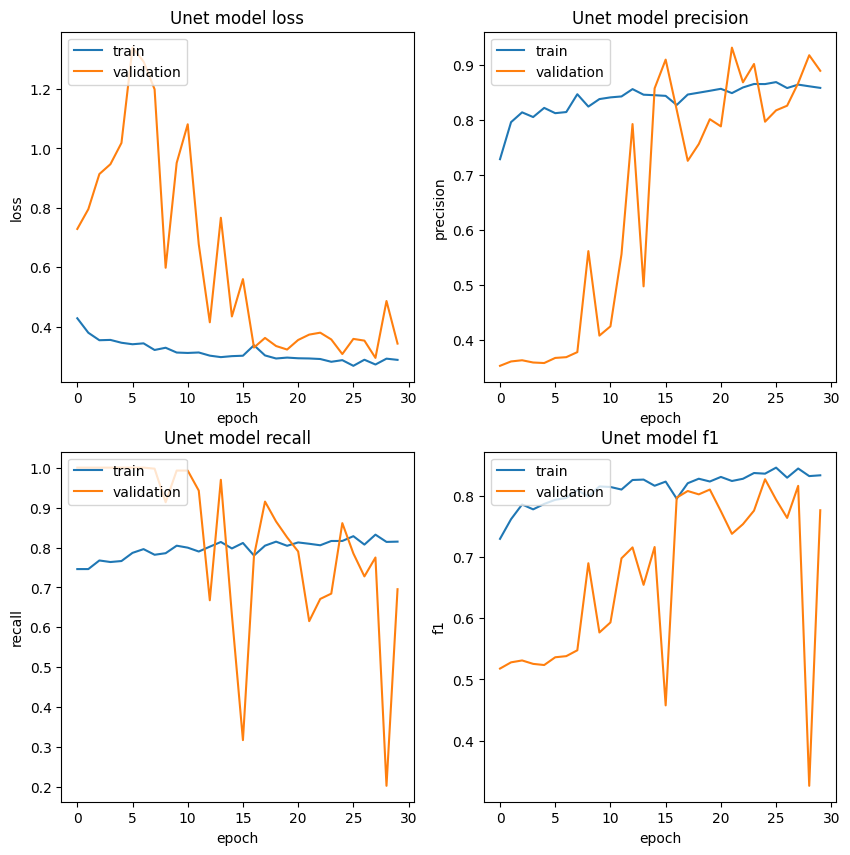

In [98]:
fig,((ax11, ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(10,10))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

**Load best model**

In [99]:
from keras.models import load_model

# Define the custom loss function before loading the model
custom_objects = {"f1_m": f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'dsc': dsc}

model = load_model('/content/drive/MyDrive/dl/flood/flood_best.keras', custom_objects=custom_objects)

# pred

In [100]:
# accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
loss, accuracy, f1_score, precision, recall, dsc = model.evaluate(test_dataset, verbose=0)
print(loss, accuracy, f1_score, precision, recall, dsc)

0.30767515301704407 0.865649938583374 0.8266023993492126 0.8043683767318726 0.8522801995277405 0.7420049905776978


**Prediction on custom images**

In [101]:
import glob
imgs = glob.glob('/content/*.jpg')

img_test = np.zeros((3, 512, 512, 3))
for index, i in enumerate(imgs):
  img = cv2.imread(i)
  img = cv2.resize(img, (512, 512))
  img = img / 255.0
  # print(img.shape)
  img_test[index] = img

In [102]:
pred = model.predict(img_test)
pred = np.where(pred > 0.5, 1, 0)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


(3, 512, 512, 1)

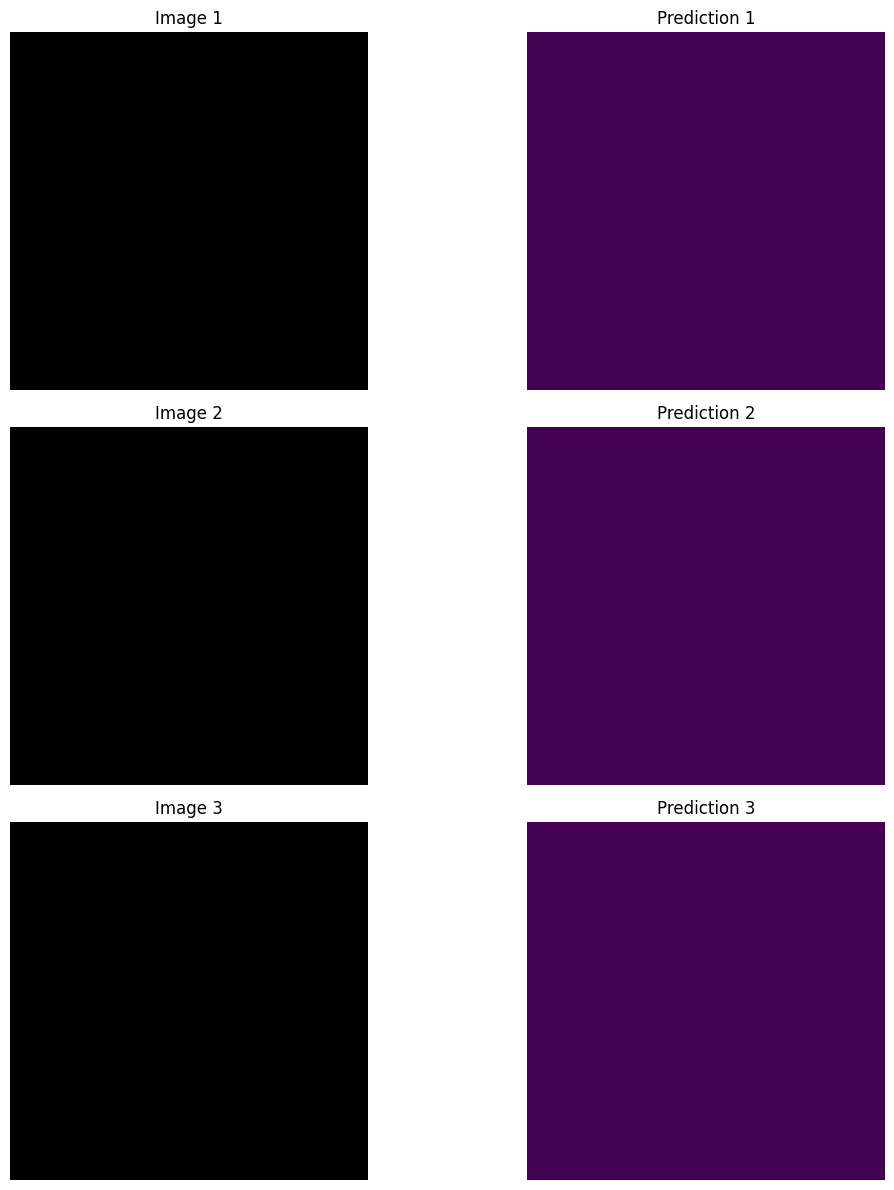

In [103]:
fig,(axes)= plt.subplots(3, 2, figsize=(12,12))

for i in range(3):
    # Load and display the original image
    axes[i, 0].imshow(img_test[i])
    axes[i, 0].set_title(f'Image {i+1}')
    axes[i, 0].axis('off')

    # Load and display the corresponding prediction
    axes[i, 1].imshow(pred[i])
    axes[i, 1].set_title(f'Prediction {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()